In [16]:
import numpy as np;
import scipy.stats;
import math;
import matplotlib.pyplot as plt;
from mpl_toolkits.mplot3d import Axes3D 
import pandas as pd

In [17]:
## ## ## ## ## #### ## ## ## ## ## 
## ## ## ## ## TASK 1: ## ## ## ##
## ## ## ## ## #### ## ## ## ## ## 


#Importing the shipdata
sd = pd.read_csv("shipdata.txt",sep="\t")

#sd["Ship type"] # Makes a list of the column "Ship types"

In [18]:
# SHIP TYPES AND NUMBER OF THEIR APPEARENCE

shipType_with_dummies = pd.get_dummies( sd["Ship type"] )# returns shipType as hot coding

print("SHIP TYPES AND NUMBER OF THEIR APPEARENCE:")
shipType_with_dummies.sum()

#sd["Ship type"].value_counts() Alternative to the above


SHIP TYPES AND NUMBER OF THEIR APPEARENCE:


Cargo     50
Tanker    48
Tug        9
dtype: int64

SCATTER PLOT OF 'Tonnage' VS 'length


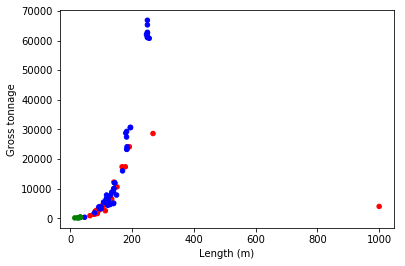

We see, that the red Cargo boat on the right is an outlier.
To distinguish it as an outlier we didn't need any transformation.


In [19]:
#SCATTER PLOT OF 'Tonnage' VS 'length'

print("SCATTER PLOT OF 'Tonnage' VS 'length")

#Example from https://stackoverflow.com/questions/31328526/scatter-plot-by-category-in-pandas

cmap = {'Cargo': 'red', 'Tanker': 'blue', 'Tug': 'green'}
sd.plot.scatter(x='Length (m)',y='Gross tonnage',color=[cmap.get(c, 'black') for c in sd["Ship type"]]) 
plt.show()

print("We see, that the red Cargo boat on the right is an outlier.")
print("To distinguish it as an outlier we didn't need any transformation.")

CORRECTING THE FALSE VALUE OF THE OUTLIER


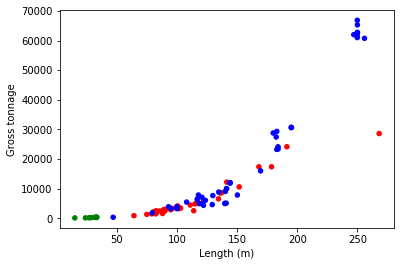

We have corrected outlier length value.


In [21]:
#CORRECTING THE FALSE VALUE OF THE OUTLIER

print("CORRECTING THE FALSE VALUE OF THE OUTLIER")

#Example from https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html
sd = sd.replace({'Length (m)': 1000.0}, 99.95)

cmap = {'Cargo': 'red', 'Tanker': 'blue', 'Tug': 'green'}
sd.plot.scatter(x='Length (m)',y='Gross tonnage',color=[cmap.get(c, 'black') for c in sd["Ship type"]]) 
plt.show()

print("We have corrected outlier length value.")

In [22]:
#'Destination' FROM CATECORIGAL TO A NUMERICAL ATTRIBUTE

print("CONVERTING 'Destination' FROM CATECORIGAL TO A NUMERICAL ATTRIBUTE")

sd = sd.join( pd.get_dummies( sd["Destination"] ) )

#sd

CONVERTING 'Destination' FROM CATECORIGAL TO A NUMERICAL ATTRIBUTE


In [23]:
#THE Z-SCORE STANDARDIZATION WITH VARIANCE NORMALIZATION

print("PERFORMING THE Z-SCORE STANDARDIZATION WITH VARIANCE NORMALIZATION TO THE ATTRIBUTES:")

# Subtracting the mean value from each attribute
sd['Speed (knots)'] = sd['Speed (knots)'] - np.mean(sd['Speed (knots)'], axis=0)
sd['Gross tonnage'] = sd['Gross tonnage'] - np.mean(sd['Gross tonnage'], axis=0)
sd['Length (m)'] = sd['Length (m)'] - np.mean(sd['Length (m)'], axis=0)
sd['Breadth (m)'] = sd['Breadth (m)'] - np.mean(sd['Breadth (m)'], axis=0)

# Dividing each attribute by their standard deviation
sd['Speed (knots)'] = sd['Speed (knots)']/np.std(sd['Speed (knots)'], axis=0)
sd['Gross tonnage'] = sd['Gross tonnage']/np.std(sd['Gross tonnage'], axis=0)
sd['Length (m)'] = sd['Length (m)']/np.std(sd['Length (m)'], axis=0)
sd['Breadth (m)'] = sd['Breadth (m)']/np.std(sd['Breadth (m)'], axis=0)

PERFORMING THE Z-SCORE STANDARDIZATION WITH VARIANCE NORMALIZATION TO THE ATTRIBUTES:


In [25]:
## ## ## ## ## #### ## ## ## ## ## 
## ## ## ## ## TASK 2: ## ## ## ##
## ## ## ## ## #### ## ## ## ## ## 


from sklearn.utils import shuffle
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

naapuria = 3

print("DEFINING A METHOD FOR RANDOMIZING AND SAMPLING THE TRAINING AND TEST DATA FOR TASK 2:")

print("In the sampling of training and test data of Task 2, we should use stratification.")
print("If we look at the distribution of ship types in the total data, we see that there are only 9 tug boats.")
print("If stratification was not done, it would be possible (and quite likely) that the training data would not contain any tug boats.")
print("If the training data would contain only few or no tug boats, the method would fail in detecting tug boats with high rate, accounting to low success rate")

# RANDOMIZING AND SAMPLING THE TRAINING AND TEST DATA
def task2Sample(sd):
    sdRand = shuffle(sd)

    # SRATIFICATION
    
    cargoRand = sdRand.loc[sdRand['Ship type'] == 'Cargo']
    tankerRand = sdRand.loc[sdRand['Ship type'] == 'Tanker']
    tugRand = sdRand.loc[sdRand['Ship type'] == 'Tug']


    cargoTrain = cargoRand.head( int(len(cargoRand)*0.7) )
    cargoTest = cargoRand.tail( len(cargoRand) - int(len(cargoRand)*0.7) )

    tankerTrain = tankerRand.head( int(len(tankerRand)*0.7) )
    tankerTest = tankerRand.tail( len(tankerRand) - int(len(tankerRand)*0.7) )

    tugTrain = tugRand.head( int(len(tugRand)*0.7) )
    tugTest = tugRand.tail( len(tugRand) - int(len(tugRand)*0.7) )


    # Combining the training (and test data) of each boat type
    training0 = cargoTrain.append( tankerTrain.append(tugTrain) )
    testing0 = cargoTest.append( tankerTest.append(tugTest) )

    return [training0, testing0]

print("DEFIINING A METHOD FOR CALCULATING THE CLASSIFICATION PERFORMANCE ACCURACY:")

def nnClassifAccur(naapuria, training0, testing0):

    # filtering the irrelevant attributes from the datasets
    crop_indices = [1] + list(range(5,23))
    training = training0.iloc[:,crop_indices]
    testing = testing0.iloc[:,crop_indices]

    # finding the nearest neighbors

    neigh = NearestNeighbors(n_neighbors = naapuria, algorithm='ball_tree').fit(training) 
    distances, indices = neigh.kneighbors(testing)


    # Saving the shiptypes of the nearest neighbors in dataframe

    columns = range(naapuria)
    nShipTypes = pd.DataFrame(index = range( len(indices) ), columns=columns)

    for k in range( len(indices) ):
        for i in columns:
            nShipTypes.set_value(k, i, training0.iloc[indices[k,i]]['Ship type'] )

    nShipTypes = nShipTypes.mode(axis=1)

    # comparing the predicted and actual type

    s = 0

    for i in range( len(nShipTypes) ):
        if (testing0.iloc[i]['Ship type'] == nShipTypes.iloc[i][0] ):
            s = s + 1
    return s / len(nShipTypes) 

DEFINING A METHOD FOR RANDOMIZING AND SAMPLING THE TRAINING AND TEST DATA FOR TASK 2:
In the sampling of training and test data of Task 2, we should use stratification.
If we look at the distribution of ship types in the total data, we see that there are only 9 tug boats.
If stratification was not done, it would be possible (and quite likely) that the training data would not contain any tug boats.
If the training data would contain only few or no tug boats, the method would fail in detecting tug boats with high rate, accounting to low success rate
DEFIINING A METHOD FOR CALCULATING THE CLASSIFICATION PERFORMANCE ACCURACY:


HISTOGRAM OF THE ACCURACY OF THE CLASSIFICATION IN TASK 2 WITH 1000 RAMDOMLY SAMPLED TRAINING AND TEST SETS:


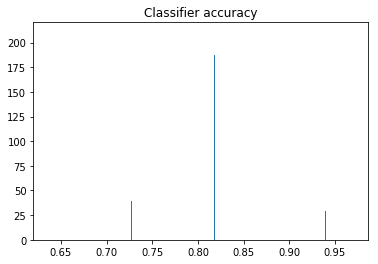

The mean of classifier accuracy is... 0.829636363636!
The standard deviation of classifier accuracy is... 0.0560000983864!!!


In [26]:
print("HISTOGRAM OF THE ACCURACY OF THE CLASSIFICATION IN TASK 2 WITH 1000 RAMDOMLY SAMPLED TRAINING AND TEST SETS:")

n_iter = 1000

task2accur = []

for i in range(n_iter):
    temp = task2Sample(sd)
    task2accur = task2accur + [ nnClassifAccur(3, temp[0], temp[1]) ] 
        
plt.hist( task2accur, n_iter )
plt.title('Classifier accuracy')

plt.show()

print( "The mean of classifier accuracy is... " + str( np.mean(task2accur) ) + "!" )
print( "The standard deviation of classifier accuracy is... " + str( np.std(task2accur) ) + "!!!" )

THE ABOVE PLOT WITH LESS BINS TO GET A MORE INTUITIVE DISTRIBUTION:


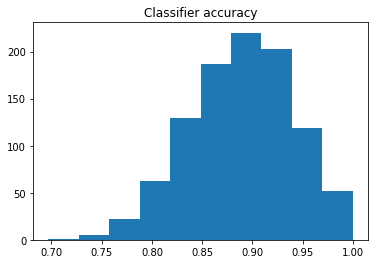

As we see from the histogram, the values of classification accuracy for all realizations are quite high, the mean being 0.875303030303.


In [10]:
print("THE ABOVE PLOT WITH LESS BINS TO GET A MORE INTUITIVE DISTRIBUTION:")# print(" asds %s asdd" %str( np.std(task2accur) )  

plt.hist( task2accur, 10)#20 )
plt.title('Classifier accuracy')

plt.show()

print("As we see from the histogram, the values of classification accuracy for all realizations are quite high, the mean being 0.875303030303.")

In [11]:
## ## ## ## ## #### ## ## ## ## ## 
## ## ## ## ## TASK 3: ## ## ## ##
## ## ## ## ## #### ## ## ## ## ## 

# SAMPLING THE TRAINING AND TEST DATA (element i is the test data)
# AKA LEAVE-ONE-OUT SAMPLING

print("DEFINING A METHOD FOR LEAVE-ONE-OUT SAMPLING METHOD:")

def task3Sample(sd, i):

    testing0 = sd.iloc[[i]]
    training0 = sd.drop(i)

    return [training0, testing0]

DEFINING A METHOD FOR LEAVE-ONE-OUT SAMPLING METHOD:


In [12]:
print("DEFINING A METHOD FOR CALCULATING THE ACCYRACY WHEN SAMPLING WITH LEAVE-ONE-OUT SAMPLING METHOD:")

def task3nnAccuracy(nn):

    sum = 0

    for i in range( len(sd) ):
        samplei = task3Sample(sd, i)
        sum = sum + nnClassifAccur(nn, samplei[0], samplei[1])

    return sum/len(sd)

DEFINING A METHOD FOR CALCULATING THE ACCYRACY WHEN SAMPLING WITH LEAVE-ONE-OUT SAMPLING METHOD:


In [13]:
print("By using the same number of nearest neighbours as in Task 2, namely k = 3, the leave-one-out sampling gives the classification accuracy of " +  str( task3nnAccuracy(3) ) )
print("In Task 2, the mean classification accuracy for k = 3 was 0.875303030303, which is slightly higher.")

By using the same number of nearest neighbours as in Task 2, namely k = 3, the leave-one-out sampling gives the classification accuracy of 0.8317757009345794
In Task 2, the mean classification accuracy for k = 3 was 0.875303030303, which is slightly higher.


In [14]:
print("CALCULATING THE ACCURACIES FOR EACH ELEMENT i LEFT OUT IN A VECTOR")

task3accur = []

for nn in range( len(sd) - 1 ):
    task3accur = task3accur + [task3nnAccuracy( 1 + nn)]

CALCULATING THE ACCURACIES FOR EACH ELEMENT i LEFT OUT IN A VECTOR


THE HISTOGRAMS OF ACCURACIES IN LEAVE-ONE-OUT SAMPLING


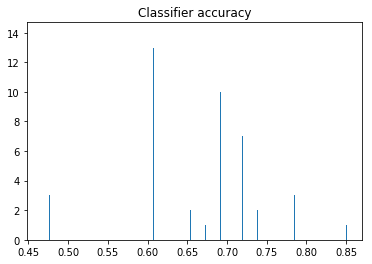

The mean of classifier accuracy is... 0.660465526362!
The standard deviation of classifier accuracy is... 0.105021851533!!!


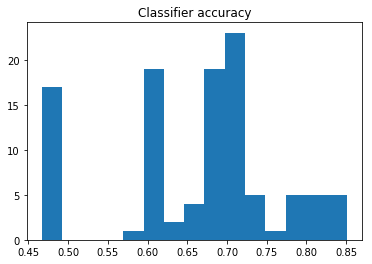

In [15]:
print("THE HISTOGRAMS OF ACCURACIES IN LEAVE-ONE-OUT SAMPLING")

plt.hist( task3accur, n_iter )
plt.title('Classifier accuracy')

plt.show()

print( "The mean of classifier accuracy is... " + str( np.mean(task3accur) ) + "!" )
print( "The standard deviation of classifier accuracy is... " + str( np.std(task3accur) ) + "!!!" )

plt.hist( task3accur, 15 )
plt.title('Classifier accuracy')

plt.show()

PLOTTING THE ACCURACY AS A FUNCTION OF THE NUMBER OR NEAREST NEIGHBOURS:


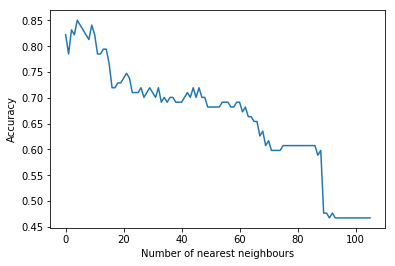

In [16]:
print("PLOTTING THE ACCURACY AS A FUNCTION OF THE NUMBER OR NEAREST NEIGHBOURS:")

plt.plot(task3accur)
plt.ylabel('Accuracy')
plt.xlabel('Number of nearest neighbours')
plt.show()

PLOTTING THE ACCURACY AS A FUNCTION OF THE NUMBER OR NEAREST NEIGHBOURS FROM 1 TO 20 NEIGHBOURS:


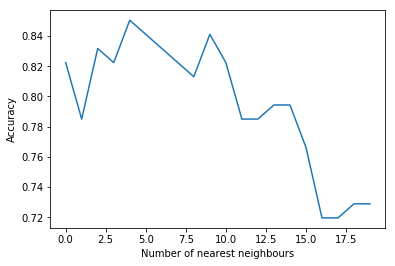

In [17]:
print("PLOTTING THE ACCURACY AS A FUNCTION OF THE NUMBER OR NEAREST NEIGHBOURS FROM 1 TO 20 NEIGHBOURS:")

task3accur20 = []

for nn in range( 20 ):
    task3accur20 = task3accur20 + [task3nnAccuracy( 1 + nn)]
    
plt.plot(task3accur20)
plt.ylabel('Accuracy')
plt.xlabel('Number of nearest neighbours')
plt.show()


In [18]:
print("We find, that the maximal classification accuracy is found for k = " + str( np.argmax(task3accur20) + 1 ) + "." )

We find, that the maximal classification accuracy is found for k = 5.


PLOTTING THE ACCURACY AS A FUNCTION OF THE NUMBER OR NEAREST NEIGHBOURS:


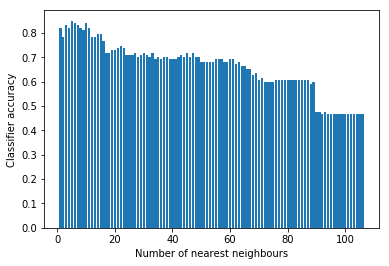

In [19]:
print("PLOTTING THE ACCURACY AS A FUNCTION OF THE NUMBER OR NEAREST NEIGHBOURS:")

bar_width = 0.35
index = np.arange( len(task3accur) ) + 0.7

plt.bar(index + bar_width, task3accur)
plt.ylabel('Classifier accuracy')
plt.xlabel('Number of nearest neighbours')


#fig.tight_layout()
plt.show()

PLOTTING THE ACCURACY AS A FUNCTION OF THE NUMBER OR NEAREST NEIGHBOURS FROM 1 TO 20 NEIGHBOURS:


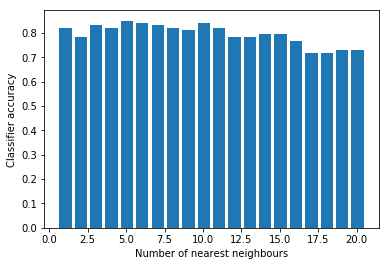

In [20]:
print("PLOTTING THE ACCURACY AS A FUNCTION OF THE NUMBER OR NEAREST NEIGHBOURS FROM 1 TO 20 NEIGHBOURS:")

bar_width = 0.35
index = np.arange( len(task3accur20) ) + 0.7

plt.bar(index + bar_width, task3accur20)
plt.ylabel('Classifier accuracy')
plt.xlabel('Number of nearest neighbours')

plt.show()

In [21]:
## ## ## ## ## #### ## ## ## ## ## 
## ## ## ## ## TASK 4: ## ## ## ##
## ## ## ## ## #### ## ## ## ## ## 

#list for numbers of nearest neighbours
nnList = range(20)

task4accur = []

for i in nnList:
    task4accur = task4accur + [nnClassifAccur(i + 1, sd, sd)]    

PLOTTING THE ACCURACY AS A FUNCTION OF THE NUMBER OR NEAREST NEIGHBOURS FROM 1 TO 20 NEIGHBOURS:


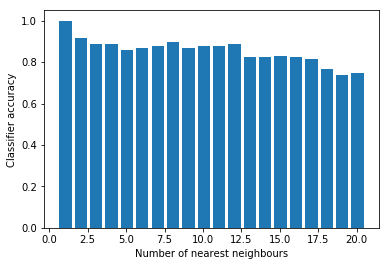

In [22]:
print("PLOTTING THE ACCURACY AS A FUNCTION OF THE NUMBER OR NEAREST NEIGHBOURS FROM 1 TO 20 NEIGHBOURS:")

bar_width = 0.35
index = np.arange( len(task4accur) ) + 0.7

plt.bar(index + bar_width, task4accur)
plt.ylabel('Classifier accuracy')
plt.xlabel('Number of nearest neighbours')

plt.show()

In [23]:
print("We find, that the maximal accuracy " + str( np.max(task4accur) ) + " is found for k = " + str( np.argmax(task4accur) + 1 ) + "." )
print("The apparent 100 % accuracy is explained by the sampling and testing sets: Since the training set contains each element of the test set, the algorithm finds the nearet neighbour of each element of the test set to be the exact same element in training set. Thus, using only one nearest neihbour, the ship type is always classified correctly.")

We find, that the maximal accuracy 1.0 is found for k = 1.
The apparent 100 % accuracy is explained by the sampling and testing sets: Since the training set contains each element of the test set, the algorithm finds the nearet neighbour of each element of the test set to be the exact same element in training set. Thus, using only one nearest neihbour, the ship type is always classified correctly.


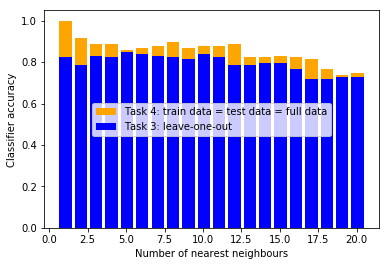

By comparing the results of task 3 and task 4, we see that for all numbers of nearest neighbours from 1 to 20 using the training data as test data gives higher accuracy than the leave-one-out sampling.

 Despite the higher accuracy in our case, the training data should not be used as testing data. 
This is because, even though in the tests the accuracy score is high, it is very misleading: in real task of classifying a sample out of the training set might fail with high probability.

To conclude, leave-one-out is better for evaluating the classification accuracy, since it gives more realistic approximation for the case of classifying data outside of the training set.


In [24]:
bar_width = 0.35
index = np.arange( len(task4accur) ) + 0.7

colors = ['blue', 'orange']
names = ['Task 3: leave-one-out','Task 4: train data = test data = full data']
legendSize = 7

plt.bar(index + bar_width, task4accur, color=colors[1], label=names[1] )
plt.bar(index + bar_width, task3accur20, color=colors[0], label=names[0] )
plt.ylabel('Classifier accuracy')
plt.xlabel('Number of nearest neighbours')
plt.legend(loc='center')
#plt.tight_layout()

plt.show()

print("By comparing the results of task 3 and task 4, we see that for all numbers of nearest neighbours from 1 to 20 using the training data as test data gives higher accuracy than the leave-one-out sampling.")
print("\n Despite the higher accuracy in our case, the training data should not be used as testing data. ")
print("This is because, even though in the tests the accuracy score is high, it is very misleading: in real task of classifying a sample out of the training set might fail with high probability.")
print("\nTo conclude, leave-one-out is better for evaluating the classification accuracy, since it gives more realistic approximation for the case of classifying data outside of the training set.")